In [ ]:
>> # ENTRO

 # Breast Cancer Detection using deep learning


 - Breast cancer is the second leading cause of cancer deaths among U.S. women, it is a type of cancer that starts when cells begin to grow out of control
 - Most breast cancers begin in the ducts that  carry milk to the nipple (ductal cancers),
 - Breast cancer can spread when the cancer cells get into the blood or lymph system and are carried to other parts of the body.
 - Cancerous breast tumors are detected by a special type of examination, which is screening mammogram

![17080.jpg](attachment:17080.jpg)

Detection of breast cancer on screening mammography is challenging as an image classification task because the tumors themselves occupy only a small portion of the image of the entire breast. For example, a full-field digital mammography (FFDM) image is typically 4000 × 3000 pixels while a potentially cancerous region of interest (ROI) can be as small as 100 × 100 pixels.



 This explains the large number that we have in the data, which is more than **a quarter of a million** images!

**Our goal:** Given a patient and a patch of a tissue slice predict wheather it contains IDC or not.

In [ ]:
import os
print(os.getcwd())

/Users/anikavyas/Desktop


>> # CODE

> # Import  Libraries

In [ ]:
import os
import numpy as np
import shutil
import pandas as pd
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
from skimage.filters import gaussian
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools


> #  Get & Adjust Data

In [ ]:
# accsess the data files
cancer_rays_dir     = os.listdir("/Users/anikavyas/Desktop/BC/archive/")
all_rays_dir        = "/Users/anikavyas/Desktop/BC/all_rays_dir/"
cancer_rays_dir_str ="/Users/anikavyas/Desktop/BC/archive/"

### what is the structure of our data?

In [ ]:
if not os.path.exists(all_rays_dir):
    os.mkdir(all_rays_dir)

In [ ]:
print(cancer_rays_dir)
print(len(cancer_rays_dir))

['9036', '10268', '10257', '8913', '13613', '8914', '15510', '10259', '16165', '10292', '12951', '10261', '10295', '9259', '12750', '13020', '16552', '12905', '9266', '16555', '13018', '9261', '9257', '12934', '12933', '9250', '10260', '10258', '10293', '9037', '10269', '16531', '10256', '15516', '12932', '12935', '9256', '16554', '9260', '13019', '16553', '13021', '8984', '9258', '12751', '9267', '12876', '12882', '15634', '12871', '14188', '15633', '9324', '12878', '.DS_Store', '9323', '9383', '8867', '9346', '9174', '12822', '9173', '9322', '9325', '12879', '14189', '12870', '12884', '12241', '15632', '12883', '12877', '9126', '13106', '12823', '13591', '9175', '12824', '9347', '9181', '9382', '10307', '13916', '10300', '14306', '15471', '16896', '14156', '9135', '12890', '12897', '10308', '10301', '10306', '12896', '14157', '12891', '12898', '14192', '13458', '9083', '9077', '13460', '8955', '12910', '9041', '14210', 'IDC_regular_ps50_idx5', '14082', '10274', '9227', '10273', '1340

##### We can see 279 files for each patient named with their id, and each file contains x-ray images of its owner

### To facilitate the process of dealing with screening mammograms images, we will collect all the images in one place, while retaining ownership of each image and its class as well...

In [ ]:
all_rays_dir_lst = os.listdir(all_rays_dir)

In [ ]:
for patient in cancer_rays_dir:
    if patient.startswith('.'):  # skip .DS_Store and hidden files
        continue

    path_0 = os.path.join(cancer_rays_dir_str, str(patient), '0')
    path_1 = os.path.join(cancer_rays_dir_str, str(patient), '1')

    if not os.path.isdir(path_0) or not os.path.isdir(path_1):
        continue  # skip if subfolder doesn't exist

    file_list_0 = os.listdir(path_0)
    file_list_1 = os.listdir(path_1)

    for fname in file_list_0:
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_rays_dir, fname)
        shutil.copyfile(src, dst)

In [ ]:
shutil.copyfile(src, dst)

'/Users/anikavyas/Desktop/BC/all_rays_dir/13021_idx5_x351_y901_class0.png'

In [ ]:
len(all_rays_dir_lst)

29676

##### Now we have 277,524 images, what a number!

### Then, it's time to put images in a data_frame for easy access:

In [ ]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()

image_id
0    9266_idx5_x1901_y701_class0.png
1  15510_idx5_x1801_y1001_class0.png
2    10295_idx5_x801_y951_class0.png
3   9036_idx5_x1051_y2401_class0.png
4    8914_idx5_x651_y1251_class0.png

In [ ]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5]
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

image_id target
0    9266_idx5_x1901_y701_class0.png      0
1  15510_idx5_x1801_y1001_class0.png      0
2    10295_idx5_x801_y951_class0.png      0
3   9036_idx5_x1051_y2401_class0.png      0
4    8914_idx5_x651_y1251_class0.png      0
5    12934_idx5_x701_y701_class0.png      0
6    9257_idx5_x1451_y601_class1.png      1
7   13613_idx5_x501_y1301_class0.png      0
8  15510_idx5_x2651_y1051_class0.png      0
9    9261_idx5_x1101_y501_class1.png      1

In [ ]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]

    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

image_id target patient_id
0    9266_idx5_x1901_y701_class0.png      0       9266
1  15510_idx5_x1801_y1001_class0.png      0      15510
2    10295_idx5_x801_y951_class0.png      0      10295
3   9036_idx5_x1051_y2401_class0.png      0       9036
4    8914_idx5_x651_y1251_class0.png      0       8914

In [ ]:
data['target'].value_counts()

target
0    23384
1     6292
Name: count, dtype: int64

#### It also seems that the number of healthy rays is greater than the number of infected rays, good news!

> # Exploratory Data Analysis

#### First of all, let's take a look at the nature of the mammograms...

## Healthy patches:


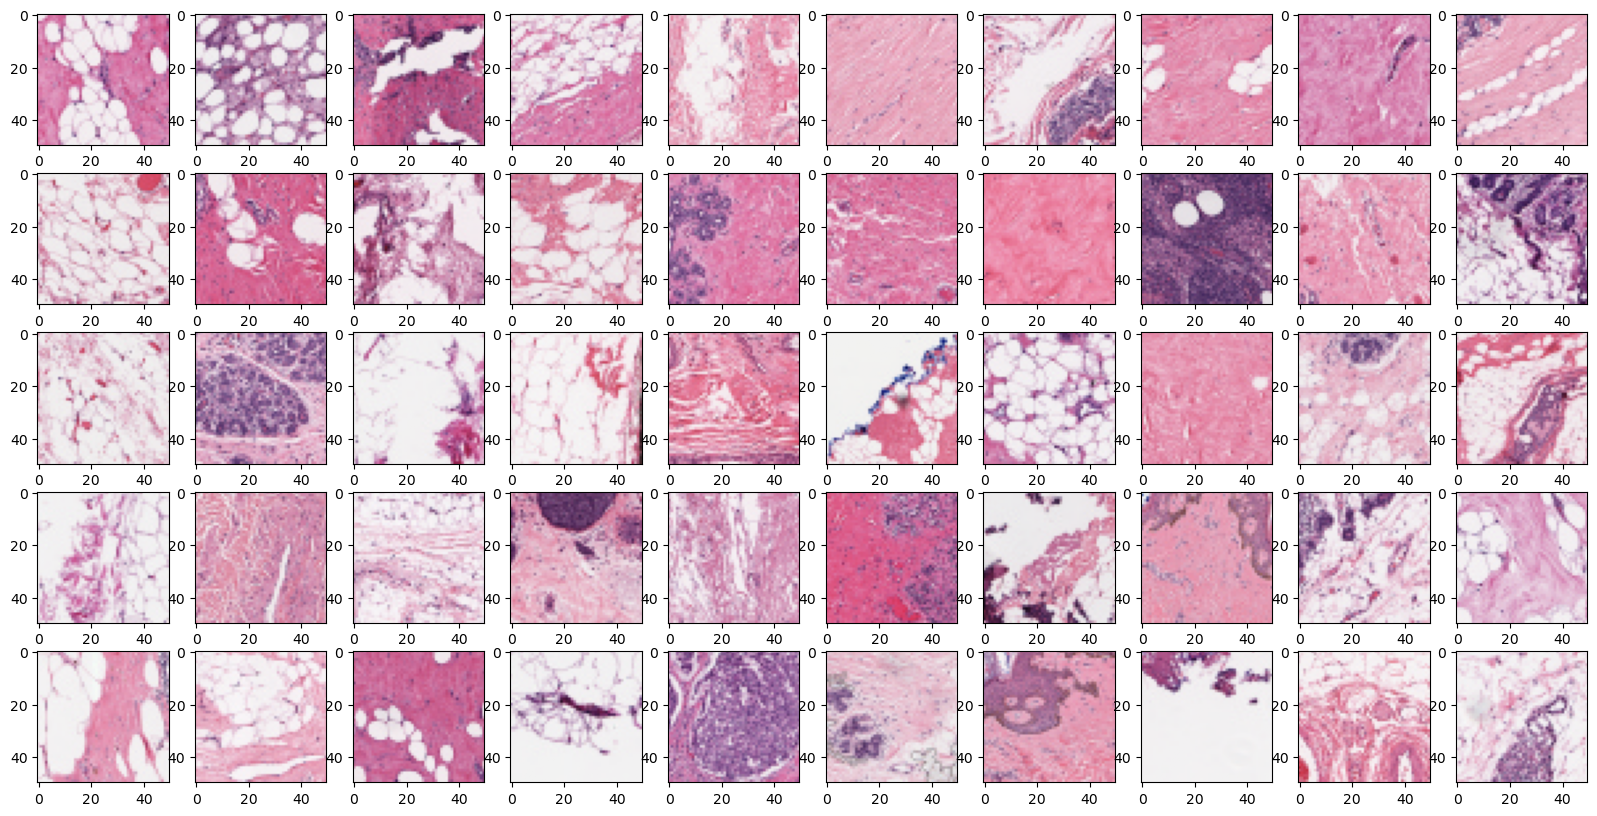

In [ ]:
data.target = data.target.astype(int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)




### Insights
- Most of the mammograms are light pink, but there are some dark ones too

# Cancer patches:

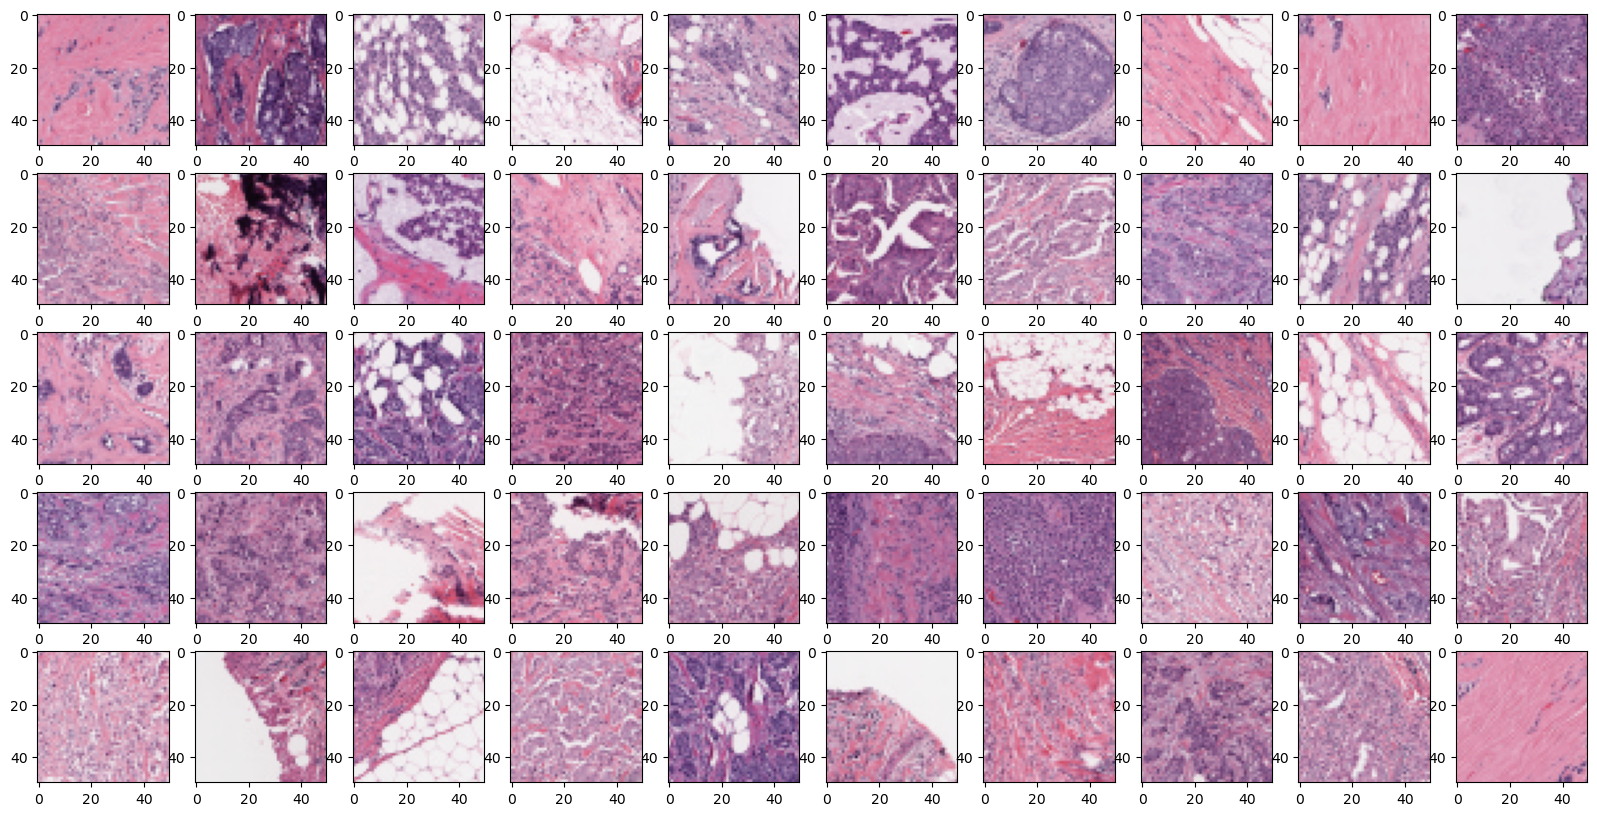

In [ ]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


### Insights

- Patches with cancer look more violet and crowded than healthy ones.
- In fact, we could not determine the actual difference between the two types with the naked eye, but I think that the model is able to detect hidden patterns in these images that enable us to determine the state of each image.

### Let's ask some questions that will help us get to know more our data:
- do all patients have the same number of mammograms?
- what is the percentage of cancer (IDC) that each mammogram shows?
- how many healthy and cancered mammograms are in the data?

/var/folders/g1/rrz63fkj39gbw4qx5mt6rs0w0000gn/T/ipykernel_68920/2648437307.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data.target, ax=ax[2], palette="Set2")


Text(0.5, 1.0, 'How many patches show IDC?')

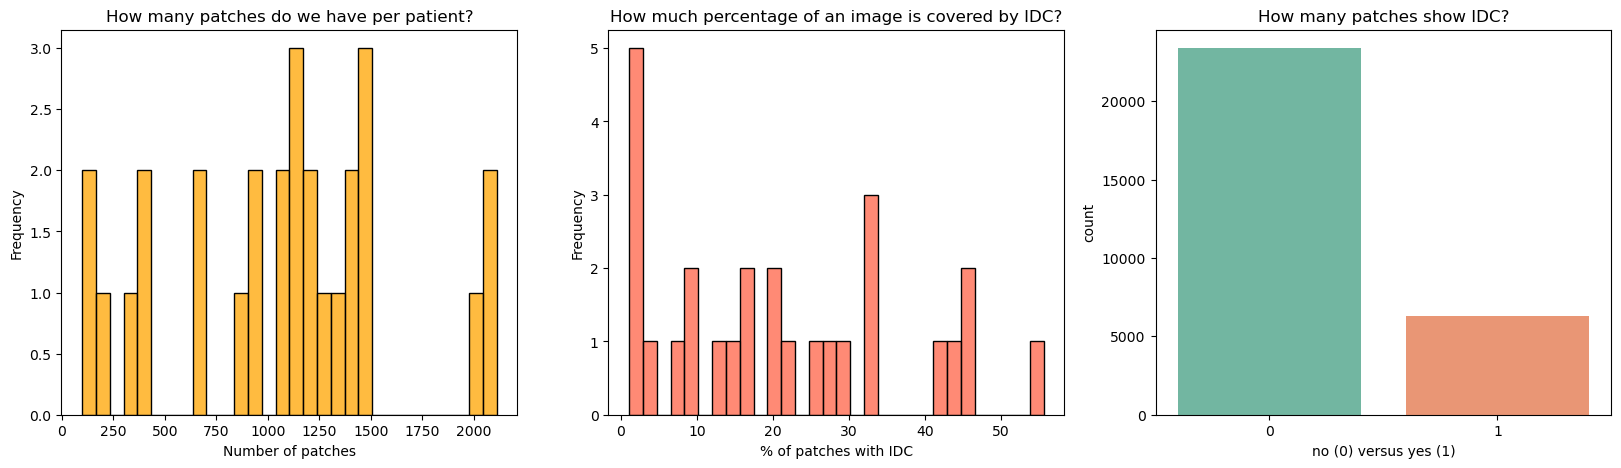

In [ ]:
# Calculate cancer percentage per patient
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

# Setup subplot grid
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Histogram: patches per patient
sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="orange", bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Histogram: IDC percentage per image
sns.histplot(cancer_perc.loc[:, 1] * 100, ax=ax[1], color="tomato", bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# Count plot: Target 0 vs 1
sns.countplot(x=data.target, ax=ax[2], palette="Set2")
ax[2].set_xlabel("no (0) versus yes (1)")
ax[2].set_title("How many patches show IDC?")

### Insights:
- The number of image patches per patient varies a lot
- Most of the photos have a percentage that is not large, but there are other photos that have a percentage of up to 80%
- the smaller number of mammograms had cancer

In [ ]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord["x"] = coord["x"].str.replace("x", "", case=False).astype(int)
    coord["y"] = coord["y"].str.replace("y", "", case=False).astype(int)
    df["x"] = coord["x"].values
    df["y"] = coord["y"].values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = cancer_rays_dir_str + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe["filename"].values
    dataframe = dataframe["filename"].str.rsplit("_", n=4, expand=True)
    dataframe["target"] = int(cancer_id)
    dataframe["path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe["x"] = dataframe["x"].str.replace("x", "", case=False).astype(int)
    dataframe["y"] = dataframe["y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df


In [ ]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1901   701       0  /Users/anikavyas/Desktop/BC/archive/9266/0/926...
1  2251  1251       0  /Users/anikavyas/Desktop/BC/archive/9266/0/926...
2   751   401       0  /Users/anikavyas/Desktop/BC/archive/9266/0/926...
3  2251   451       0  /Users/anikavyas/Desktop/BC/archive/9266/0/926...
4   351  1501       0  /Users/anikavyas/Desktop/BC/archive/9266/0/926...

### Well let's take a closer look at the shape of the patches and their distribution in each mammogram using Binary objective visualization for each tissue slice:

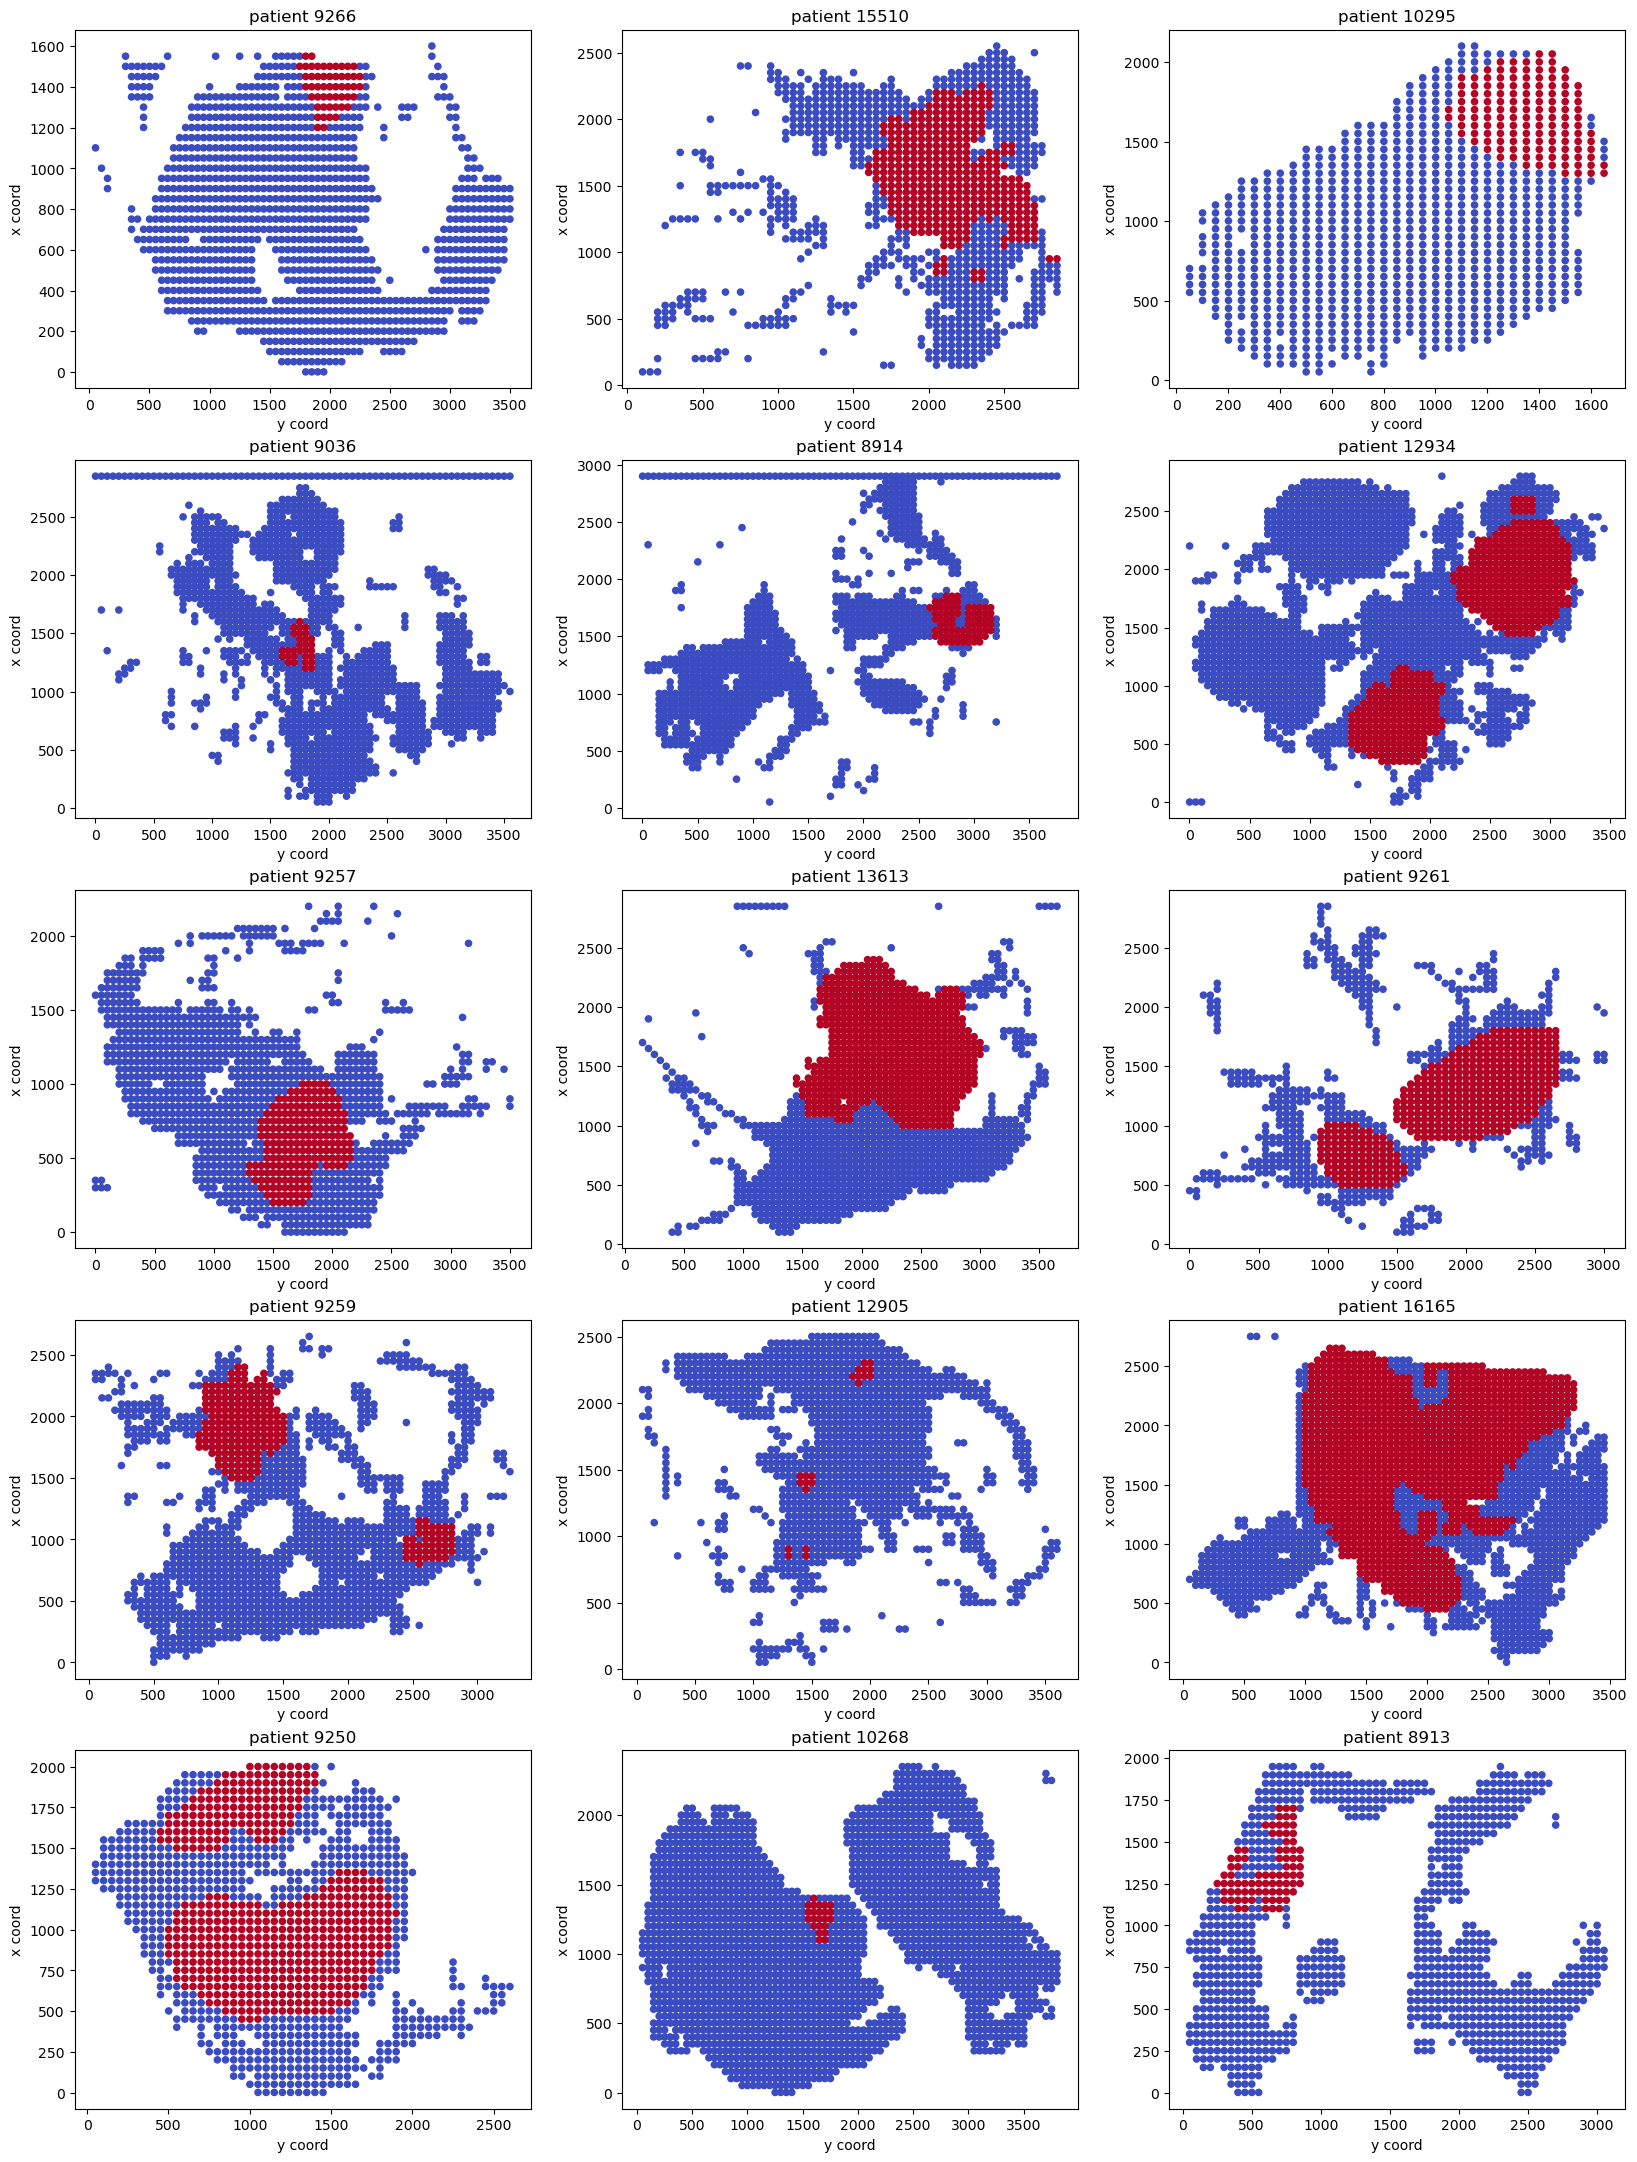

In [ ]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)

        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights:

- We see a large variation in the concentration of cells
- Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.

> # Processing and selection
it's time to work on our data..

# Image Processing

-  Apply some processing properties

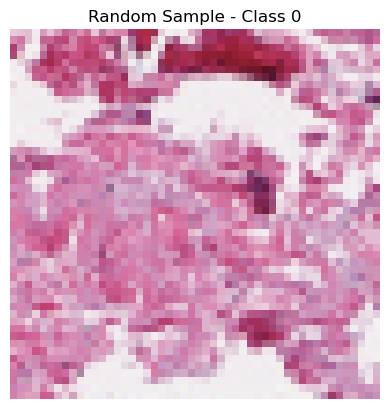

In [ ]:
data["target"] = data["target"].astype(int)

# Select a random image index from the negative class (target == 0)
random_index = np.random.choice(data[data["target"] == 0].index, size=1, replace=False)

# Build the image path
path = os.path.join(all_rays_dir, data.loc[random_index[0], 'image_id'])

# Load and display the image
image = mpimg.imread(path)
plt.imshow(image)
plt.axis('off')  # Optional: makes the display cleaner
plt.title("Random Sample - Class 0")
plt.show()

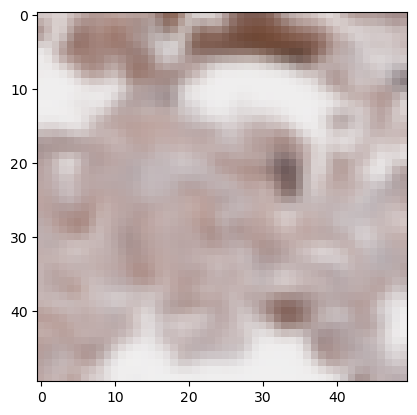

In [ ]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image)

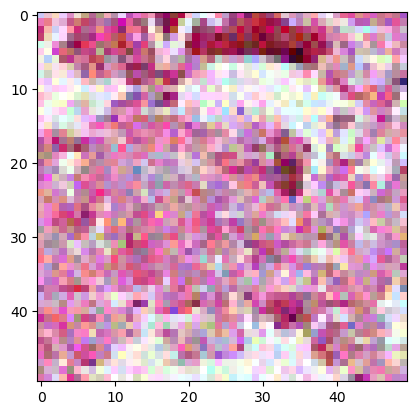

In [ ]:
noise_image = random_noise(image)
plt.imshow(noise_image)

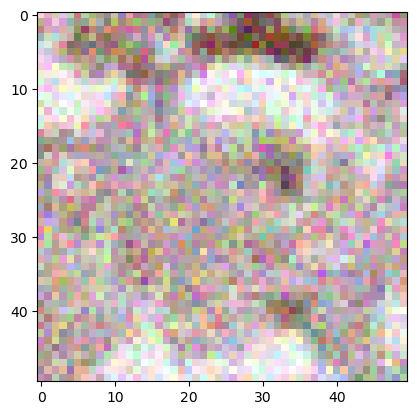

In [ ]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

-  Processing using [random_noise] function

In [ ]:
import os
from skimage.util import random_noise
import matplotlib.image as mpimg

# Make sure the directories exist
os.makedirs('Desktop/final_proj/image_processing/noise_images', exist_ok=True)


In [ ]:
# Loop over the image filenames
for normal_image in all_rays_dir_lst:
    path = os.path.join(all_rays_dir, normal_image)

    # Read the image
    img = mpimg.imread(path)

    # Add noise to the image
    noise_image = random_noise(img)

    # Save the noisy image
    new_path = os.path.join('Desktop/final_proj/image_processing/noise_images', normal_image)
    mpimg.imsave(new_path, noise_image)


In [ ]:
os.makedirs('Desktop/final_proj/image_processing/processed_data_train/zeros', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/processed_data_train/ones', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/processed_data_test/zeros', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/processed_data_test/ones', exist_ok=True)


In [ ]:
# List the processed image files
processed_lst = os.listdir('Desktop/final_proj/image_processing/noise_images')

# Construct path to noise images
processed_lst_str = 'Desktop/final_proj/image_processing/noise_images'

# Convert to DataFrame
processed_data = pd.DataFrame(processed_lst, columns=['image_id'])

# Preview the data
processed_data.head()

image_id
0    9266_idx5_x1901_y701_class0.png
1  15510_idx5_x1801_y1001_class0.png
2    10295_idx5_x801_y951_class0.png
3   9036_idx5_x1051_y2401_class0.png
4    8914_idx5_x651_y1251_class0.png

In [ ]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5]  # Get the 6th character of the string at index 5
    return target

# Ensure `processed_data` is the DataFrame you're working with (not `processd_data`)
processed_data['target'] = processed_data['image_id'].apply(extract_target)

processed_data.head(10)

image_id target
0    9266_idx5_x1901_y701_class0.png      0
1  15510_idx5_x1801_y1001_class0.png      0
2    10295_idx5_x801_y951_class0.png      0
3   9036_idx5_x1051_y2401_class0.png      0
4    8914_idx5_x651_y1251_class0.png      0
5    12934_idx5_x701_y701_class0.png      0
6    9257_idx5_x1451_y601_class1.png      1
7   13613_idx5_x501_y1301_class0.png      0
8  15510_idx5_x2651_y1051_class0.png      0
9    9261_idx5_x1101_y501_class1.png      1

In [ ]:
processed_data['target'].value_counts()

target
0    23384
1     6292
Name: count, dtype: int64

In [ ]:
import shutil
import os

# Assuming `processd_test` is a list of image filenames from processed data for the test set
for image in processed_data['image_id']:
    fname = image
    target = processed_data.loc[processed_data['image_id'] == image, 'target'].values[0]

    if target == '0':
        label = 'zeros'
    elif target == '1':
        label = 'ones'
    else:
        continue  # Skip if the target is neither '0' nor '1'

    src = os.path.join(processed_lst_str, fname)
    dst = os.path.join("Desktop/final_proj/image_processing/processed_data_test", label, fname)

    # Ensure the destination folder exists
    os.makedirs(os.path.dirname(dst), exist_ok=True)

    # Copy file
    shutil.copyfile(src, dst)


In [ ]:
# Ensure `processed_data` is defined correctly and set the index
processed_data.set_index('image_id', inplace=True)

# Assuming `processd_train` is a list of image filenames or the train data subset from `processed_data`
# If you haven't defined `processd_train`, you can use processed_data directly, filtering for train data
processd_train = processed_data.index  # or processed_data[processed_data['set'] == 'train'].index

# Iterate over the training set and copy files
for image in processd_train:
    fname = image
    target = processed_data.loc[image, 'target']

    if target == '0':
        label = 'zeros'
    elif target == '1':
        label = 'ones'
    else:
        continue  # Skip if the target is neither '0' nor '1'

    # Source and destination paths
    src = os.path.join(processed_lst_str, fname)
    dst = os.path.join('Desktop/final_proj/image_processing/processed_data_train', label, fname)

    # Ensure the destination folder exists
    os.makedirs(os.path.dirname(dst), exist_ok=True)

    # Copy file to the destination
    shutil.copyfile(src, dst)

In [ ]:
print(len(os.listdir('Desktop/final_proj/image_processing/processed_data_train/zeros')))
print(len(os.listdir('Desktop/final_proj/image_processing/processed_data_train/ones')))
print(len(os.listdir('Desktop/final_proj/image_processing/processed_data_test/zeros')))
print(len(os.listdir('Desktop/final_proj/image_processing/processed_data_test/ones')))

23384
6292
23384
6292


# Processing  and Normal test

-  the images we processed and the noraml are tested on the same model to see which the best in the accuracy

-  A small sample is taken for testing (20,000) images

### First: the processed images

In [ ]:
os.makedirs('Desktop/final_proj/image_processing/model_tst/training/zeros', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/model_tst/training/ones', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/model_tst/testing/zeros', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/model_tst/testing/ones', exist_ok=True)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import os

# Ensure `processd_data` is loaded correctly
# This assumes `processd_data` is a DataFrame, make sure you have it from previous steps
# If it's not loaded, load it from a file (e.g., CSV or other formats)
# processd_data = pd.read_csv("your_data.csv")  # Example for CSV loading

# Sample 10000 entries for each target class '0' and '1'
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)

# Combine the two DataFrames for testing
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']

# Split into training and test sets
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)

# Get image IDs for training and testing
sts_train = test_data_train.image_id
tst_test = test_data_test.image_id

# Set the index to image_id
test_data.set_index('image_id', inplace=True)

# Ensure destination directories exist
os.makedirs('Desktop/final_proj/image_processing/model_tst/training/zeros', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/model_tst/training/ones', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/model_tst/testing/zeros', exist_ok=True)
os.makedirs('Desktop/final_proj/image_processing/model_tst/testing/ones', exist_ok=True)

# Copy files for training set
for image in sts_train:
    fname = image
    target = test_data.loc[image, 'target']

    if target == '0':
        label = 'zeros'
    elif target == '1':
        label = 'ones'

    # Source and destination paths
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('Desktop/final_proj/image_processing/model_tst/training', label, fname)

    # Copy the file
    shutil.copyfile(src, dst)

# Copy files for testing set
for image in tst_test:
    fname = image
    target = test_data.loc[image, 'target']

    if target == '0':
        label = 'zeros'
    elif target == '1':
        label = 'ones'

    # Source and destination paths
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('Desktop/final_proj/image_processing/model_tst/testing', label, fname)

    # Copy the file
    shutil.copyfile(src, dst)


NameError: name 'processd_data' is not defined

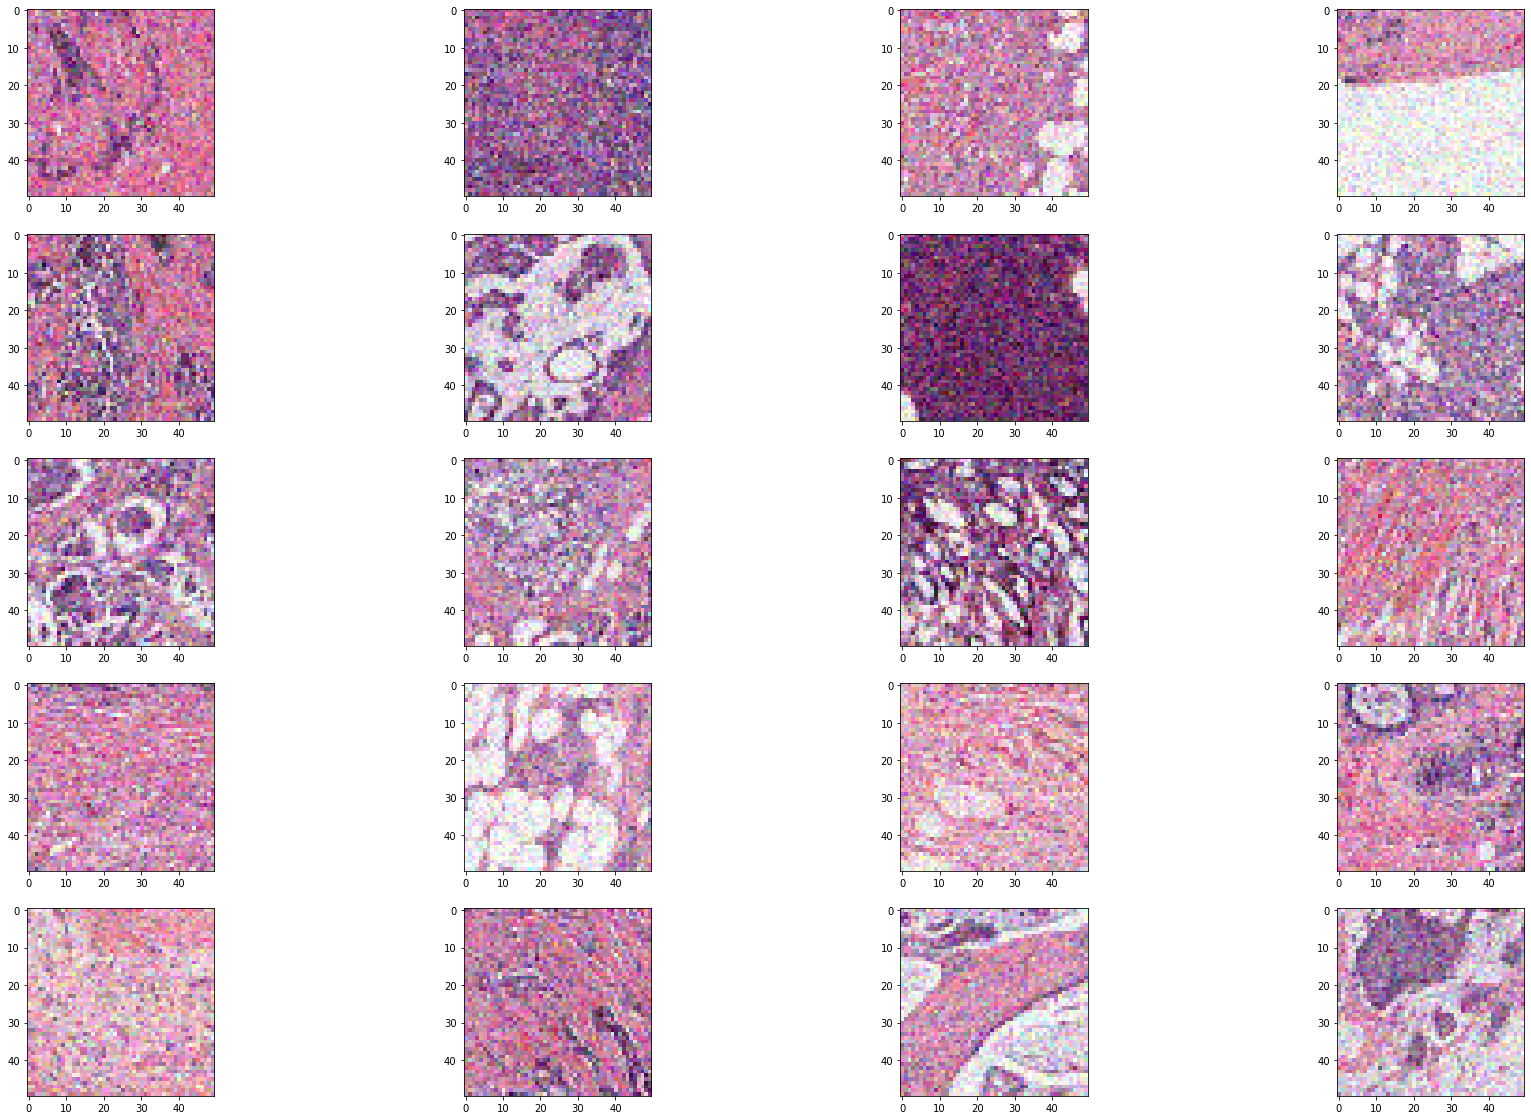

In [ ]:
processd_data.target = processd_data.target.astype(np.int)
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

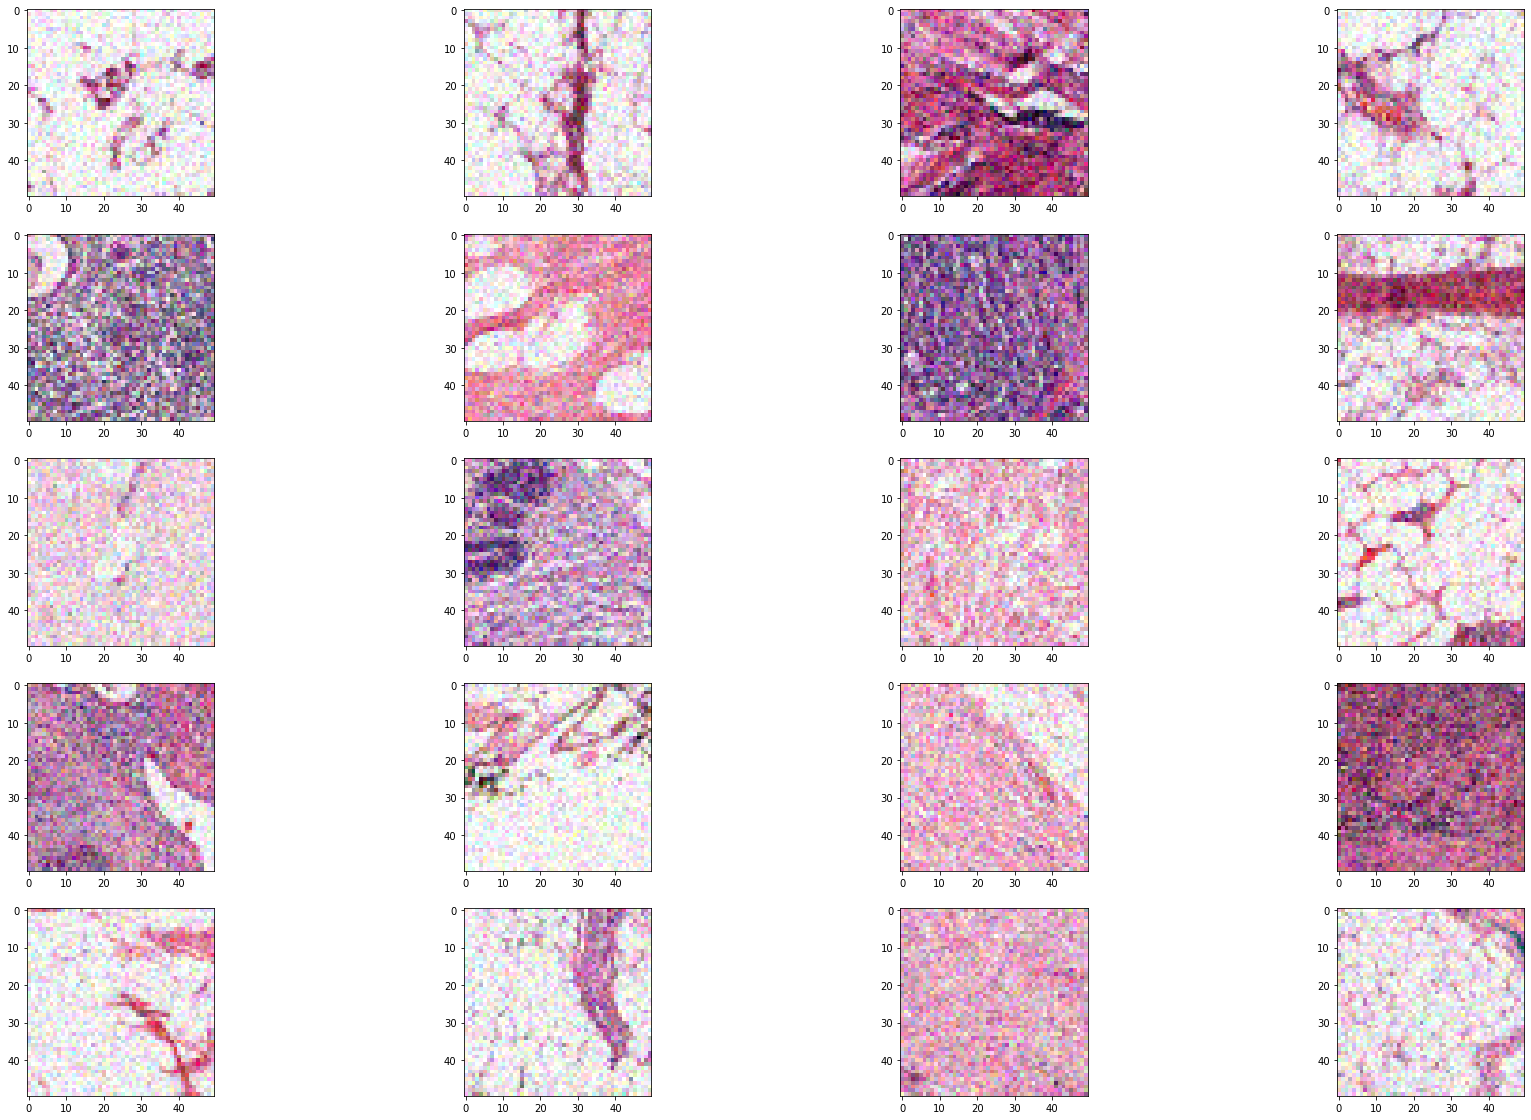

In [ ]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [ ]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("Desktop\\final_proj\\image_processing\\model_tst\\trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("Desktop\\final_proj\\image_processing\\model_tst\\testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit_generator(train_generation_processd,validation_data=test_generation_processd,epochs=60, verbose=1,callbacks=early_stop)

C:\Users\zeado\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
1800/1800 [==============================] - 344s 190ms/step - loss: 0.5252 - accuracy: 0.7552 - val_loss: 0.5818 - val_accuracy: 0.7180
Epoch 2/60
1800/1800 [==============================] - 100s 55ms/step - loss: 0.4949 - accuracy: 0.7704 - val_loss: 0.4938 - val_accuracy: 0.7660
Epoch 3/60
1800/1800 [==============================] - 102s 57ms/step - loss: 0.4715 - accuracy: 0.7891 - val_loss: 0.4551 - val_accuracy: 0.7985
Epoch 4/60
1800/1800 [==============================] - 102s 57ms/step - loss: 0.4558 - accuracy: 0.7974 - val_loss: 0.4683 - val_accuracy: 0.7950
Epoch 5/60
1800/1800 [==============================] - 100s 56ms/step - loss: 0.4391 - accuracy: 0.8053 - val_loss: 0.5133 - val_accuracy: 0.7670


### Second: the normal images

In [ ]:
os.mkdir( 'Desktop\\final_proj\\image_processing\\normal')
os.mkdir( 'Desktop\\final_proj\\image_processing\\normal\\model_tst')
os.mkdir( 'Desktop\\final_proj\\image_processing\\normal\\model_tst\\trainig')
os.mkdir( 'Desktop\\final_proj\\image_processing\\normal\\model_tst\\testing')
os.mkdir( 'Desktop\\final_proj\\image_processing\\normal\\model_tst\\trainig\\zeros')
os.mkdir( 'Desktop\\final_proj\\image_processing\\normal\\model_tst\\trainig\\ones')
os.mkdir( 'Desktop\\final_proj\\image_processing\\normal\\model_tst\\testing\\zeros')
os.mkdir( 'Desktop\\final_proj\\image_processing\\normal\\model_tst\\testing\\ones')

In [ ]:
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('Desktop\\final_proj\\image_processing\\normal\\model_tst\\trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('Desktop\\final_proj\\image_processing\\normal\\model_tst\\testing', label, fname)
    shutil.copyfile(src, dst)


In [ ]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("Desktop\\final_proj\\image_processing\\normal\\model_tst\\trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("Desktop\\final_proj\\image_processing\\normal\\model_tst\\testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit_generator(train_generation_normal,validation_data=test_generation_normal,epochs=60, verbose=1,callbacks=early_stop)

C:\Users\zeado\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
1800/1800 [==============================] - 332s 184ms/step - loss: 0.4209 - accuracy: 0.8166 - val_loss: 0.5193 - val_accuracy: 0.7650
Epoch 2/60
1800/1800 [==============================] - 92s 51ms/step - loss: 0.4273 - accuracy: 0.8151 - val_loss: 0.4623 - val_accuracy: 0.7905
Epoch 3/60
1800/1800 [==============================] - 93s 52ms/step - loss: 0.3895 - accuracy: 0.8341 - val_loss: 0.4769 - val_accuracy: 0.7850
Epoch 4/60
1800/1800 [==============================] - 95s 53ms/step - loss: 0.3602 - accuracy: 0.8439 - val_loss: 0.5446 - val_accuracy: 0.7935


## conclusion : Normal images are the best in modeling

> # Modeling

# Data Spliting & Generation

In [ ]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [ ]:
print(data_train.shape)
print(data_test.shape)

(222019, 2)
(55505, 2)


In [ ]:
os.mkdir( 'Desktop\\final_proj\\train_dir')
os.mkdir('Desktop\\final_proj\\test_dir')

In [ ]:
os.mkdir( 'Desktop\\final_proj\\train_dir\\zeros')
os.mkdir( 'Desktop\\final_proj\\train_dir\\ones')

os.mkdir( 'Desktop\\final_proj\\test_dir\\zeros')
os.mkdir( 'Desktop\\final_proj\\test_dir\\ones')


In [ ]:
train = data_train.image_id
test  = data_test.image_id

In [ ]:
data.set_index('image_id', inplace=True)
for image in train:
    fname  = image
    target = data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('Desktop\\final_proj\\train_dir', label, fname)
    shutil.copyfile(src, dst)

In [ ]:
for image in test:
    fname = image
    target = data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join("Desktop\\final_proj\\test_dir", label, fname)
    shutil.copyfile(src, dst)


In [ ]:
print('non-IDC train      =',len(os.listdir('Desktop\\final_proj\\train_dir\\zeros')))
print('IDC train          =',len(os.listdir('Desktop\\final_proj\\train_dir\\ones')))
print('non-IDC validation =',len(os.listdir('Desktop\\final_proj\\test_dir\\zeros')))
print('IDC validation     =',len(os.listdir('Desktop\\final_proj\\test_dir\\ones')))

non-IDC train      = 178864
IDC train          = 70907
non-IDC validation = 19874
IDC validation     = 7879


In [ ]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generation = data_generation.flow_from_directory(
                                        "Desktop\\final_proj\\train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "Desktop\\final_proj\\test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')



Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


># Model design

In [ ]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [ ]:
my_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 22, 22, 32)        1568      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 19, 19, 32)        16416     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               663808    
_________________________________________________________________
dense_15 (Dense)             (None, 2)               

In [ ]:
my_model.fit_generator(train_generation,validation_data=test_generation,epochs=60, verbose=1,callbacks=early_stop)

C:\Users\zeado\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
24978/24978 [==============================] - 1335s 53ms/step - loss: 0.4165 - accuracy: 0.8204 - val_loss: 0.4191 - val_accuracy: 0.8226
Epoch 2/60
24978/24978 [==============================] - 1315s 53ms/step - loss: 0.3874 - accuracy: 0.8341 - val_loss: 0.3622 - val_accuracy: 0.8422
Epoch 3/60
24978/24978 [==============================] - 1395s 56ms/step - loss: 0.3748 - accuracy: 0.8392 - val_loss: 0.3814 - val_accuracy: 0.8431
Epoch 4/60
24978/24978 [==============================] - 1420s 57ms/step - loss: 0.3650 - accuracy: 0.8436 - val_loss: 0.3392 - val_accuracy: 0.8541
Epoch 5/60
24978/24978 [==============================] - 1274s 51ms/step - loss: 0.3564 - accuracy: 0.8485 - val_loss: 0.3362 - val_accuracy: 0.8554
Epoch 6/60
24978/24978 [==============================] - 1272s 51ms/step - loss: 0.3508 - accuracy: 0.8505 - val_loss: 0.3341 - val_accuracy: 0.8591
Epoch 7/60
24978/24978 [==============================] - 1293s 52ms/step - loss: 0.3464 - accuracy:

># Outputs and Outcomes

In [ ]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

loss  accuracy  val_loss  val_accuracy
0  0.416507  0.820387  0.419071      0.822614
1  0.387389  0.834056  0.362227      0.842179
2  0.374838  0.839233  0.381375      0.843080
3  0.365002  0.843617  0.339223      0.854142
4  0.356424  0.848453  0.336158      0.855367

<AxesSubplot:>

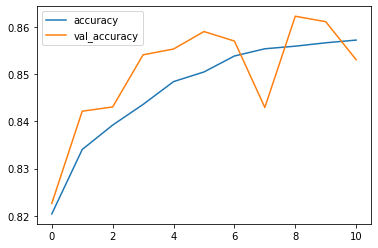

In [ ]:
losse[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

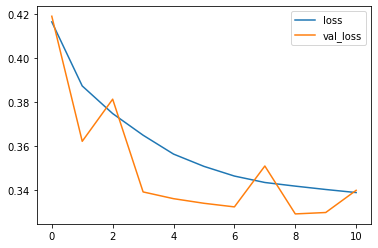

In [ ]:
losse[['loss','val_loss']].plot()


In [ ]:
val_loss, val_acc = \
my_model.evaluate_generator(test_generation)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

C:\Users\zeado\anaconda3\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.33995357155799866
val_acc: 0.8530969619750977


## model results :

- After several attempts, we made a good model design
- Our model have a good acc = 85.4 %
- over fitting is so small
- We're ready to create APIs

> # Save &Loaded Model

In [ ]:
model_json = my_model.to_json()

In [ ]:
with open("Desktop\\final_proj\\GUI\\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
my_model.save_weights("Desktop\\final_proj\\GUI\\model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Loaded model from disk


> # APIs &  Web Localization

- we will use this class to connect the web app to the model

In [ ]:
class Api_service :
    def __init__(self,img_file_path):
        self.img_file_path = img_file_path
    def prediction_function(self) :
        predict_generation = data_generation.flow_from_directory(
                                            self.img_file_path,
                                            target_size=(25,25),
                                            batch_size=10,
                                            class_mode='categorical')

        prediction = loaded_model.predict_generator(predict_generation)
        has_cancer = 'The percentage of cancer : '+ str(round(prediction[0][1]*100,2)) + "%"
        has_no_cancer='Percentage of no cancer : ' + str(round(prediction[0][0]*100,2)) + '%'
        return has_cancer,has_no_cancer


In [ ]:
prediction = Api_service("Desktop\\final_proj\\predict")
x,y        = prediction.prediction_function()
print(x)
print(y)

Found 1 images belonging to 1 classes.
The percentage of cancer : 97.91%
Percentage of no cancer : 2.09%
